# VGG + BRAIN TUMOR

In [1]:
# ! pip install torch torchvision numpy pydantic interpret faiss-cpu torchsummary matplotlib pandas seaborn scikit-learn scikit-image pytorch-lightning[extra] --no-cache-dir --ignore-installed

In [2]:
import copy
import os
import pickle
import logging
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from data.brain_tumor_mri import BrainTumorMRI
from models.vgg import VGG
from pytorch_lightning import Trainer, seed_everything

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Timer
from pytorch_lightning.callbacks import RichProgressBar

from pytorch_lightning.loggers import CSVLogger
from torchvision import transforms
from torchvision.transforms import functional as F

from helpers.prediction import get_labels_from_prediction
from helpers.metrics import metrics_to_dataframe
from report.plots import plot_loss_curve, plot_acc_curve, plot_analysis
from report import basic_report

seed_everything(42, workers=True)
pd.set_option('display.max_rows', None)

Global seed set to 42


In [3]:
BATCH_SIZE = 64
VAL_SIZE = 0.3
EPOCHS = 60
DATASET_RANDOM = 37

brain_tumor = BrainTumorMRI(val_size=VAL_SIZE, batch_size=BATCH_SIZE, random_state=DATASET_RANDOM, transformations=transforms.Compose(
            [
                transforms.Resize((255, 255)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ))

# MODEL

In [4]:
model = VGG(num_classes=4)

timer = Timer()
progress_bar = RichProgressBar()
logger = CSVLogger(save_dir="./", name=f"experiments-1/{model.name}", flush_logs_every_n_steps=1)
checkpoint_callback = ModelCheckpoint(
    filename=f"{model.name}-" + "{epoch}-{train_loss:.4f}-{train_acc:.4f}-{val_loss:.4f}-{val_acc:.4f}",
    save_top_k=3, save_last=True, monitor="val_loss", mode="min", verbose=True
)

trainer = Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCHS,
    logger=logger,
    callbacks=[timer, progress_bar, checkpoint_callback],
    log_every_n_steps=1,    
    # enable_progress_bar=False,
    # limit_train_batches=DATASET_RATIO or 1.0,
    # limit_val_batches=DATASET_RATIO or 1.0,
    # limit_test_batches=DATASET_RATIO or 1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## TRAINING

In [5]:
trainer.fit(
    model,
    train_dataloaders=brain_tumor.train_dataloader,
    val_dataloaders=brain_tumor.val_dataloader
)

┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name              ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss_fn           │ CrossEntropyLoss   │      0 │
│ 1 │ train_acc         │ MulticlassAccuracy │      0 │
│ 2 │ val_acc           │ MulticlassAccuracy │      0 │
│ 3 │ test_acc          │ MulticlassAccuracy │      0 │
│ 4 │ feature_extractor │ Sequential         │ 14.7 M │
│ 5 │ avgpool           │ AdaptiveAvgPool2d  │      0 │
│ 6 │ classifier        │ Sequential         │  119 M │
└───┴───────────────────┴────────────────────┴────────┘

Trainable params: 16.4 K                                                                                           
Non-trainable params: 134 M                                                                                        
Total params: 134 M                                                                                                
Total estimated model params size (MB): 537

Output()

Epoch 0, global step 63: 'val_loss' reached 0.90577 (best 0.90577), saving model to './experiments-1/vgg/version_0/checkpoints/vgg-epoch=0-train_loss=1.1351-train_acc=0.5358-val_loss=0.9058-val_acc=0.7351.ckpt' as top 3
Epoch 1, global step 126: 'val_loss' reached 0.73312 (best 0.73312), saving model to './experiments-1/vgg/version_0/checkpoints/vgg-epoch=1-train_loss=0.8284-train_acc=0.7136-val_loss=0.7331-val_acc=0.7783.ckpt' as top 3
Epoch 2, global step 189: 'val_loss' reached 0.64217 (best 0.64217), saving model to './experiments-1/vgg/version_0/checkpoints/vgg-epoch=2-train_loss=0.6982-train_acc=0.7701-val_loss=0.6422-val_acc=0.8098.ckpt' as top 3
Epoch 3, global step 252: 'val_loss' reached 0.59167 (best 0.59167), saving model to './experiments-1/vgg/version_0/checkpoints/vgg-epoch=3-train_loss=0.6352-train_acc=0.7894-val_loss=0.5917-val_acc=0.8127.ckpt' as top 3
Epoch 4, global step 315: 'val_loss' reached 0.54967 (best 0.54967), saving model to './experiments-1/vgg/version_0/c

## TESTING

In [6]:
batch_predictions = trainer.predict(model, dataloaders=brain_tumor.test_dataloader)
truth_labels, preds_labels = get_labels_from_prediction(batch_predictions)
with open(f"{trainer.logger.log_dir}/{model.name}-preds.dump", "wb") as f:
    pickle.dump([truth_labels, preds_labels], f)

Output()

## ANALYSIS

In [7]:
train_metrics, valid_metrics, epoch_metrics = metrics_to_dataframe(f"{trainer.logger.log_dir}/metrics.csv", brain_tumor)

/Users/arthuralvim/Work/xai-clustering/helpers/metrics.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics["epoch"] = metrics["epoch"].fillna(method="ffill")
/Users/arthuralvim/Library/Caches/pypoetry/virtualenvs/xai-clustering-b3gHD5dt-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


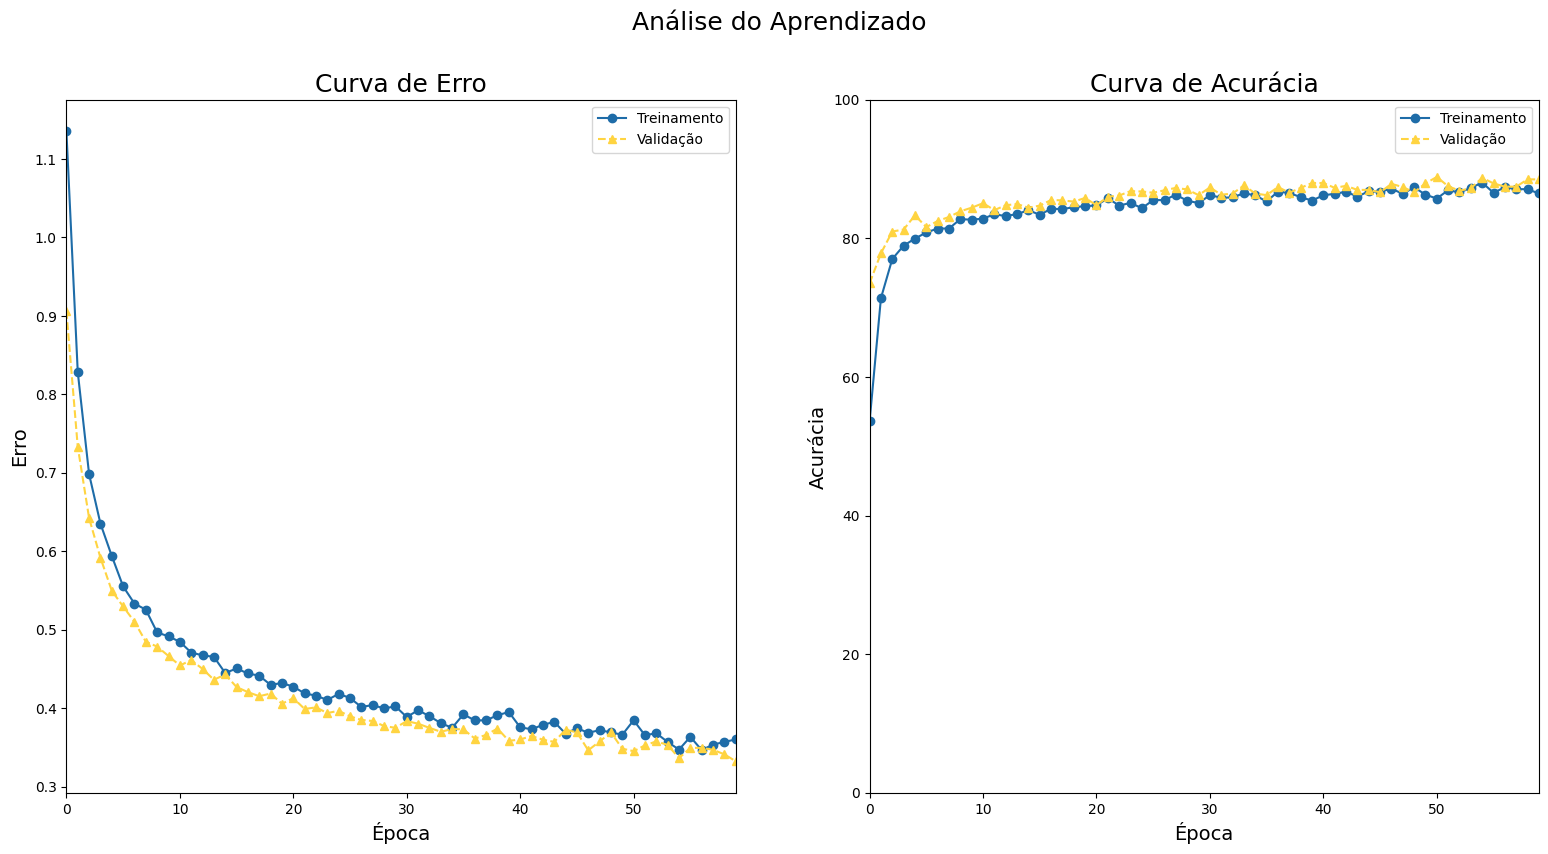

In [8]:
plot_analysis(epoch_metrics, save_as=f"{trainer.logger.log_dir}/{model.name}-analysis.png")

In [9]:
plot_loss_curve(epoch_metrics, show=False, save_as=f"{trainer.logger.log_dir}/{model.name}-loss.png")
plot_acc_curve(epoch_metrics, show=False, save_as=f"{trainer.logger.log_dir}/{model.name}-acc.png")
basic_report(truth_labels, preds_labels, labels=[0,1,2,3], label_names=["Glioma", "Meningioma", "Sem Tumor", "Pituitária"], show=False, 
             save_as=f"{trainer.logger.log_dir}/{model.name}-confusion-matrix.png")

              precision    recall  f1-score   support

      Glioma      0.888     0.763     0.821       300
  Meningioma      0.735     0.699     0.717       306
   Sem Tumor      0.900     0.956     0.927       405
  Pituitária      0.870     0.963     0.915       300

    accuracy                          0.854      1311
   macro avg      0.848     0.845     0.845      1311
weighted avg      0.852     0.854     0.851      1311

            Gli  Men  Sem  Pit
Glioma      229   62    0    9
Meningioma   21  214   40   31
Sem Tumor     6    9  387    3
Pituitária    2    6    3  289
